# Computing a threshold

In this tutorial, we will present different ways to compute the threshold of the 2D toric code using PanQEC. The first method consists in explicitly writing a loop over physical error rates and system sizes, and calculating the failure rates for each parameter. The second method is more powerful and uses PanQEC's higher-level functions. It outputs a result dataframe from which the error bars, the threshold, the subthreshold scaling factor, and other metrics can be computed automatically.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# uncomment if you use a dark background:
# plt.style.use('dark_background')

import IPython

## Method 1: step-by-step

In [2]:
from panqec.codes import Toric2DCode
from panqec.error_models import PauliErrorModel
from panqec.decoders import MatchingDecoder

We start by initializing all the models needed in our simulation

In [3]:
sizes = [4, 6, 8]
error_rates = np.linspace(0.01, 0.5, 20)

codes = [Toric2DCode(L) for L in sizes]
error_model = PauliErrorModel(1/3, 1/3, 1/3)
decoders = [[MatchingDecoder(code, error_model, p) 
             for p in error_rates] for code in codes]

We can now run our main loop to estimate the logical error rate for all the sizes and physical error rates. 

In [4]:
def plot_threshold(logical_error_rates, i_run, n_runs):
    """Plot routine on loop."""

    plt.clf()
    for i_size in range(len(sizes)):
        plt.plot(error_rates, logical_error_rates[i_size], '-o', label=f"L={sizes[i_size]}")
    plt.title(f'Run {i_run + 1} / {n_runs}')
    plt.xlabel('Physical Error Rate', fontsize=20)
    plt.ylabel('Logical Error Rate', fontsize=20)
    plt.legend()
    
    # For updating the plot dynamically in the loop
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())

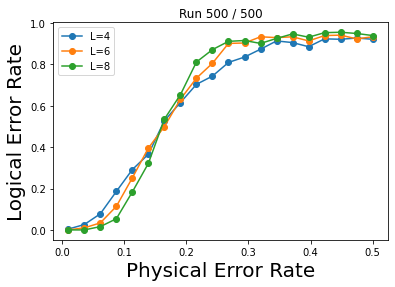

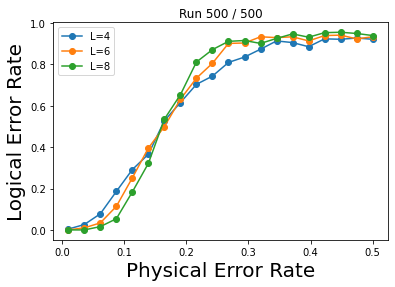

In [5]:
n_runs = 500
plot_every = 5

n_failures = np.zeros((len(sizes), len(error_rates)))

for i_run in range(n_runs):
    for i_size in range(len(sizes)):
        for i_p in range(len(error_rates)):
            error = error_model.generate(codes[i_size], error_rates[i_p])
            syndrome = codes[i_size].measure_syndrome(error)
            correction = decoders[i_size][i_p].decode(syndrome)
            
            residual_error = (error + correction) % 2
            in_codespace = codes[i_size].in_codespace(residual_error)
            is_logical_error = codes[i_size].is_logical_error(residual_error)
            
            failure = is_logical_error or not in_codespace
            
            n_failures[i_size, i_p] += int(failure)
    
    logical_error_rates = n_failures / (i_run + 1)
    
    if (i_run + 1) % plot_every == 0:
        plot_threshold(logical_error_rates, i_run, n_runs)

## Method 2: using an input dictionary

We will now describe how to compute the same threshold automatically, by just providing an input dictionary with all our parameters

In [6]:
from panqec.analysis import get_results_df_from_batch, get_thresholds_df
from panqec.plots import threshold_plot

from panqec.simulation import (
    read_input_dict
)
import datetime

from tqdm.notebook import tqdm
import IPython.display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We first provide the dictionary:

In [7]:
# Parameters
# Change these as you wish.

input_data = {
    'ranges': {
        'label': 'toric-2d',
        'code': {
            'model': 'Toric2DCode',
            'parameters': [
                {'L_x': 4},
                {'L_x': 6},
                {'L_x': 8},
            ]
        },
        'noise': {
            'model': 'PauliErrorModel',
            'parameters': [
                {'r_x': 0.33, 'r_y': 0.33, 'r_z': 0.34}
            ],
        },
        'decoder': {
            'model': 'BeliefPropagationOSDDecoder',
            'parameters': [{'osd_order': 0}]
        },
        'probability': np.linspace(0.01, 0.5, 20).tolist()
    }
}

We now load the input dictionary using the function `read_input_dict`. It returns an instance of `BatchSimulation` from which we can run our simulations with the specified parameters.

In [8]:
# Frequency of plot update
plot_frequency = 10

# Frequency of saving to file.
save_frequency = 100

# Target number of simulations.
n_trials = 500

# We create a BatchSimulation by reading the input dictionary
batch_sim = read_input_dict(
    input_data,
    update_frequency=plot_frequency,
    save_frequency=save_frequency
)

The following function is used to plot the threshold curve in real-time during the computation:

In [9]:
def update_plot():
    """Plot routine on loop."""
    remaining_time = batch_sim.estimate_remaining_time(n_trials)
    df = pd.DataFrame(batch_sim.get_results())


    plt.clf()
    for code_size in df['size'].unique():
        df_filtered = df[df['size'] == code_size]
        plt.errorbar(
            df_filtered['probability'], df_filtered['p_est'],
            yerr=df_filtered['p_se'],
            label=f'L={code_size[0]}'
        )
    plt.title(f'Time remaining {datetime.timedelta(seconds=int(remaining_time))}')
    plt.xlabel('Physical Error Rate', fontsize=20)
    plt.ylabel('Logical Error Rate', fontsize=20)
    plt.legend()
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
    
batch_sim.on_update = update_plot

We now run the experiment. It should plot the new curve every 10 iterations (`plot_frequency`), and save the results to a file (contained by default in the `temp/` folder) every 100 iterations (`save_frequency`). If you interrupt the simulation or destroy the notebook kernel, it should restart from the last saved results.

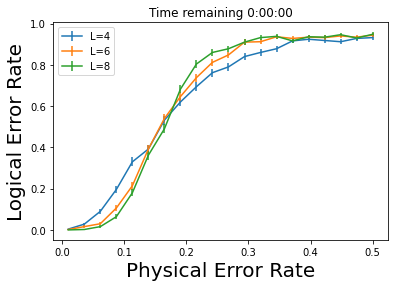

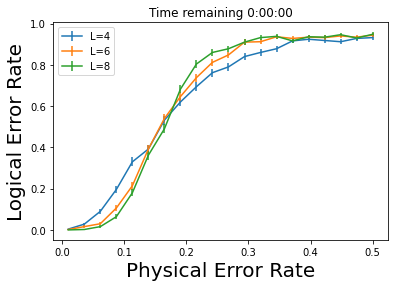

In [10]:
batch_sim.run(n_trials, progress=tqdm)

### Analyzing the results

We can now perform a finite-size scaling analysis to extract the threshold. The first step is to extract a result dataframe (in a `pd.DataFrame` format):

In [11]:
results_df = get_results_df_from_batch(batch_sim, input_data['ranges']['label'])
results_df.head(10)

,size,code,n,k,d,error_model,probability,n_success,n_fail,n_runs,p_est,p_se,label,noise_direction,p_x,p_x_se,p_z,p_z_se
0,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.010000,498,2,500,0.004,0.002820,toric-2d,"(0.33, 0.33, 0.34)",0.004,0.002820,0.000,0.000000
1,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.035789,486,14,500,0.028,0.007370,toric-2d,"(0.33, 0.33, 0.34)",0.022,0.006553,0.006,0.003450
2,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.061579,455,45,500,0.090,0.012786,toric-2d,"(0.33, 0.33, 0.34)",0.044,0.009163,0.052,0.009919
3,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.087368,402,98,500,0.196,0.017735,toric-2d,"(0.33, 0.33, 0.34)",0.112,0.014090,0.120,0.014518
4,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.113158,335,165,500,0.330,0.021008,toric-2d,"(0.33, 0.33, 0.34)",0.196,0.017735,0.208,0.018133
5,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.138947,304,196,500,0.392,0.021811,toric-2d,"(0.33, 0.33, 0.34)",0.248,0.019294,0.248,0.019294
6,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.164737,234,266,500,0.532,0.022293,toric-2d,"(0.33, 0.33, 0.34)",0.338,0.021133,0.334,0.021071
7,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.190526,190,310,500,0.620,0.021685,toric-2d,"(0.33, 0.33, 0.34)",0.396,0.021850,0.398,0.021869
8,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.216316,153,347,500,0.694,0.020588,toric-2d,"(0.33, 0.33, 0.34)",0.490,0.022334,0.452,0.022235
9,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.242105,119,381,500,0.762,0.019026,toric-2d,"(0.33, 0.33, 0.34)",0.516,0.022327,0.552,0.022217


We then extract the threshold using a finite-size scaling method. The result is a dataframe `thresholds_df`, with two important keys for us: `p_th_fss` and `p_th_fss_se`, which represent the estimated threshold and its standard deviation (calculated using bootstrapping).

In [16]:
thresholds_df, trunc_results_df, params_bs_list = get_thresholds_df(results_df, 
                                                                    ftol_est=1e-3,
                                                                    ftol_std=1e-3,
                                                                    maxfev=10000)
thresholds_df

,error_model,noise_direction,r_x,r_y,r_z,eta_x,eta_y,eta_z,p_th_sd,p_th_nearest,p_left,p_right,p_th_fss,p_th_fss_left,p_th_fss_right,p_th_fss_se,fss_params
0,Pauli X0.3300Y0.3300Z0.3400,"(0.33, 0.33, 0.34)",0.33,0.33,0.34,0.492537,0.492537,0.515152,0.139,0.164737,0.113,0.164,0.140235,0.13888,0.141901,0.005617,"(0.12605263157894736, 2.9782150384735773, 0.40..."


We finally plot the resulting curve along with the estimated threshold:

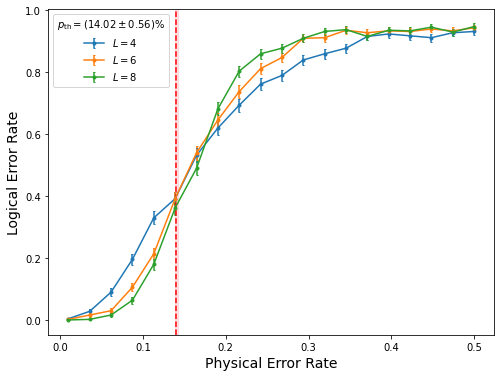

In [17]:
threshold_plot(plt, results_df, thresholds_df, figsize=(8,6))